In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
from scipy.interpolate import interp2d
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from Map import ly_noise,heii_noise,civ_noise,lyemissioncube,\
heiiemissioncube,civemissioncube,heiivelocitymap,civvelocitymap,\
heiispec,civspec

### Some functions

In [5]:
def interpolate_grid(x,y,img,xnew,ynew,method='linear'):
    
    interfunc=interp2d(y,x,img,kind=method)
    img_inter=interfunc(ynew,xnew)
    return img_inter

def radiu_profile(x,y):
    
    x_mesh,y_mesh=np.meshgrid(y,x)
    r_mesh=np.sqrt((x_mesh**2)+(y_mesh**2))
    return r_mesh


def velocity_sigma(img_nb,flux_noise,velo,velo_axis):
    
    velo_cube=np.ones((velo_axis.size,velo.shape[0],velo.shape[1]))
    for i in range(velo_axis.size):
        velo_cube[i,:,:]=velo_axis[i]*velo_cube[i,:,:]
    
    v_sigma=(flux_noise/img_nb)*np.sqrt(((velo_cube-velo)**2).sum(axis=0))
    
    return v_sigma

def img_bin(img1,img2,snr1,snr2,snr3,sigma1,sigma2,r_mesh,v1,v2,v_sigma1,v_sigma2,
            nx,ny,delta_x=5,delta_y=5):
    
    lib1,lib2,r_lib,lib_sigma1,lib_sigma2,lib_v1,lib_v2,lib_vs1,lib_vs2=[],[],[],[],[],[],[],[],[]
    for i in range(nx,img1.shape[0]-nx,nx+delta_x):
        for j in range(ny,img1.shape[1]-ny,ny+delta_y):
            cell01=img1[i-nx:i+nx,j-ny:j+ny]
            cell02=img2[i-nx:i+nx,j-ny:j+ny]
            cellsnr1=snr1[i-nx:i+nx,j-ny:j+ny]
            cellsnr2=snr2[i-nx:i+nx,j-ny:j+ny]
            cellsnr3=snr3[i-nx:i+nx,j-ny:j+ny]
            jud1=(cellsnr1>3.5)
            jud2=(cellsnr2>3.5)
            jud3= (cellsnr3>3.)
            cell11=cell01[jud1]#&jud3]
            cell12=cell02[jud2]#&jud3]
            
            scell01=sigma1[i-nx:i+nx,j-ny:j+ny]
            scell02=sigma2[i-nx:i+nx,j-ny:j+ny]
            scell11=scell01[jud1]#&jud3]
            scell12=scell02[jud2]#&jud3]
            
            vcell01=v1[i-nx:i+nx,j-ny:j+ny]
            vcell02=v2[i-nx:i+nx,j-ny:j+ny]
            vcell11=vcell01[jud1]#&jud3]
            vcell12=vcell02[jud2]#&jud3]
            
            vscell01=v_sigma1[i-nx:i+nx,j-ny:j+ny]
            vscell02=v_sigma2[i-nx:i+nx,j-ny:j+ny]
            vscell11=vscell01[jud1]#&jud3]
            vscell12=vscell02[jud2]#&jud3]
            if (cell11.size>0)&(cell12.size>0):
                lib1.append(cell11.mean())
                lib2.append(cell12.mean())
                lib_sigma1.append(np.median(scell11)/np.sqrt(scell11.size))
                lib_sigma2.append(np.median(scell12)/np.sqrt(scell12.size))
                lib_v1.append(np.median(vcell11))
                lib_v2.append(np.median(vcell12))
                lib_vs1.append(np.median(vscell11))
                lib_vs2.append(np.median(vscell12))
                r=r_mesh[i-nx:i+nx,j-ny:j+ny]
                r_lib.append(r.min())
                snr1[i-nx:i+nx,j-ny:j+ny]=0.
    
    return np.array(lib1),np.array(lib2),np.array(r_lib) \
,np.array(lib_sigma1),np.array(lib_sigma2),np.array(lib_v1),np.array(lib_v2) \
,np.array(lib_vs1),np.array(lib_vs2),snr1

def img_bin2(img1,img2,snr1,snr2,snr3,r_mesh,nx,ny,delta_x=5,delta_y=5):
    
    lib1,lib2,r_lib=[],[],[]
    for i in range(nx,img1.shape[0]-nx,nx+delta_x):
        for j in range(ny,img1.shape[1]-ny,ny+delta_y):
            cell01=img1[i-nx:i+nx,j-ny:j+ny]
            cell02=img2[i-nx:i+nx,j-ny:j+ny]
            cellsnr1=snr1[i-nx:i+nx,j-ny:j+ny]
            cellsnr2=snr2[i-nx:i+nx,j-ny:j+ny]
            cellsnr3=snr3[i-nx:i+nx,j-ny:j+ny]
            jud1=(cellsnr1>3.2)
            jud2=(cellsnr2>3.2)
#             jud3= (cellsnr3>3.5)
            cell11=cell01[jud1]#&jud3]
            cell12=cell02[jud2]#&jud3]
            if (cell11.size>0)&(cell12.size>0):
                lib1.append(cell11.min())
                lib2.append(cell12.min())
                r=r_mesh[i-nx:i+nx,j-ny:j+ny]
                r_lib.append(r.min())

    return np.array(lib1),np.array(lib2),np.array(r_lib)

### import and generate SNR map

$\rm \sigma_{A/B}=(A/B)\sqrt{(\sigma_{A}/A)^{2}+(\sigma_{B}/B)^{2}}=\rm \sqrt{(1/SNR_{A})^{2}+(1/SNR_{B})^{2}}$

$\sigma_{\rm A}=\sqrt{N} \ \sigma_{\lambda}$

Subaru NB image for H$\alpha$ filter: BrG centering on 2.165$\mu$m with width 0.025$\mu$m
the redshift range is $[2.28,2.32]$

This redshift range corresponds to ly$\alpha$ wavelength range: $[3988,4037]$; (4002,4037)

HeII wavelength range: $[5380,5445]$; (5425,5445)

CIV wavelength range: $[5080,5143]$; (5123,5143)

emission threshold: $3\sigma$

In [6]:
ly_nb=lyemissioncube.optimal_img*1e-17
heii_nb=heiiemissioncube.optimal_img*1e-17
civ_nb=civemissioncube.optimal_img*1e-17
heiivelo=heiivelocitymap.copy()
civvelo=civvelocitymap.copy()

heii_judge=np.ones_like(heii_nb).astype(np.bool)
heii_judge[25:44,9:]=False
civ_judge=np.ones_like(civ_nb).astype(np.bool)
civ_judge[23:46,8:]=False

ly_noise1=ly_noise*1e-17*np.sqrt(lyemissioncube.shape[0])
heii_noise1=heii_noise*1e-17*np.sqrt(heiiemissioncube.shape[0])
civ_noise1=civ_noise*1e-17*np.sqrt(civemissioncube.shape[0])

lysnr=ly_nb/ly_noise1
heiisnr=heii_nb/heii_noise1
civsnr=civ_nb/civ_noise1

heii_v_sigma=velocity_sigma(heiiemissioncube.optimal_img,
                            heii_noise,heiivelocitymap,
                            heiispec)
civ_v_sigma=velocity_sigma(civemissioncube.optimal_img,
                           civ_noise,civvelocitymap,
                           civspec)

ly_nb[lysnr<=3]=3*ly_noise1
heii_nb[(heiisnr<=3)|(heii_judge)]=3*heii_noise1
civ_nb[(civsnr<=3)|(civ_judge)]=3*civ_noise1
heiivelo[(heiisnr<=3)|(heii_judge)]=0
civvelo[(civsnr<=3)|(civ_judge)]=0
heii_v_sigma[(heiisnr<=3)|(heii_judge)]=0
civ_v_sigma[(civsnr<=3)|(civ_judge)]=0


kcwi_ra=heiiemissioncube.ra.to(u.arcsec).value
kcwi_dec=heiiemissioncube.dec.to(u.arcsec).value

In [7]:
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
h_alpha=np.genfromtxt(dic+'H-alpha_intensity.txt')
h_alpha_ra=np.genfromtxt(dic+'H-alpha_ra.txt')-.8
h_alpha_dec=np.genfromtxt(dic+'H-alpha_dec.txt')-4
h_alpha_noise=1.1877882e-18
h_alpha[h_alpha<=0]=3*h_alpha_noise
h_alpha_snr=h_alpha/h_alpha_noise

interpolate the images

In [8]:
ra_inter=np.linspace(kcwi_ra.min(),kcwi_ra.max(),400)
dec_inter=np.linspace(kcwi_dec.min(),kcwi_dec.max(),400)

ly_img=interpolate_grid(kcwi_ra,kcwi_dec,ly_nb,ra_inter,dec_inter)
heii_img=interpolate_grid(kcwi_ra,kcwi_dec,heii_nb,ra_inter,dec_inter)
civ_img=interpolate_grid(kcwi_ra,kcwi_dec,civ_nb,ra_inter,dec_inter)
h_alpha_img=interpolate_grid(h_alpha_dec,h_alpha_ra,h_alpha,ra_inter,dec_inter)


lysnr=interpolate_grid(kcwi_ra,kcwi_dec,lysnr,ra_inter,dec_inter)
civsnr=interpolate_grid(kcwi_ra,kcwi_dec,civsnr,ra_inter,dec_inter)
heiisnr=interpolate_grid(kcwi_ra,kcwi_dec,heiisnr,ra_inter,dec_inter)
h_alpha_snr=interpolate_grid(h_alpha_dec,h_alpha_ra,h_alpha_snr,ra_inter,dec_inter)

heiivelo=interpolate_grid(kcwi_ra,kcwi_dec,heiivelo,ra_inter,dec_inter)
civvelo=interpolate_grid(kcwi_ra,kcwi_dec,civvelo,ra_inter,dec_inter)

heiivsigma=interpolate_grid(kcwi_ra,kcwi_dec,heii_v_sigma,ra_inter,dec_inter)
civvsigma=interpolate_grid(kcwi_ra,kcwi_dec,civ_v_sigma,ra_inter,dec_inter)

align the four images

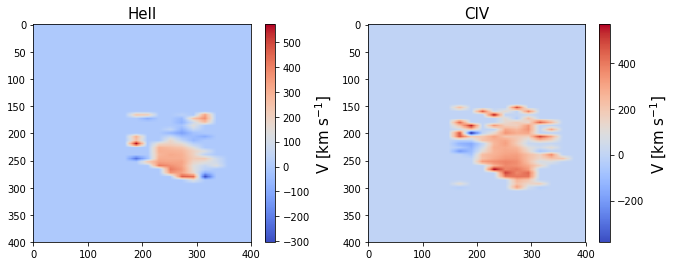

In [10]:
fig,ax=plt.subplots(1,2)
img=ax[0].imshow(heiivelo,cmap='coolwarm')
ax[0].set_title('HeII',fontsize=15)
cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'V [km s$^{-1}$]',fontsize=15)
img=ax[1].imshow(civvelo,cmap='coolwarm')
ax[1].set_title('CIV',fontsize=15)
cbar=plt.colorbar(img,ax=ax[1])
cbar.ax.set_ylabel(r'V [km s$^{-1}$]',fontsize=15)

plt.rcParams['figure.figsize'] = [11, 4]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
# plt.savefig(savdic+'V.png',dpi=300)

In [11]:
ly_img=np.rot90(ly_img)[:,::-1]
heii_img=np.rot90(heii_img)[:,::-1]
civ_img=np.rot90(civ_img)[:,::-1]
h_alpha_img=h_alpha_img[:,::-1]

heiivelo=np.rot90(heiivelo)[:,::-1]
civvelo=np.rot90(civvelo)[:,::-1]
heiivsigma=np.rot90(heiivsigma)[:,::-1]
civvsigma=np.rot90(civvsigma)[:,::-1]

lysnr=ly_img/ly_noise1
heiisnr=heii_img/heii_noise1
civsnr=civ_img/civ_noise1
h_alpha_snr=h_alpha_img/h_alpha_noise

calculate the ratio

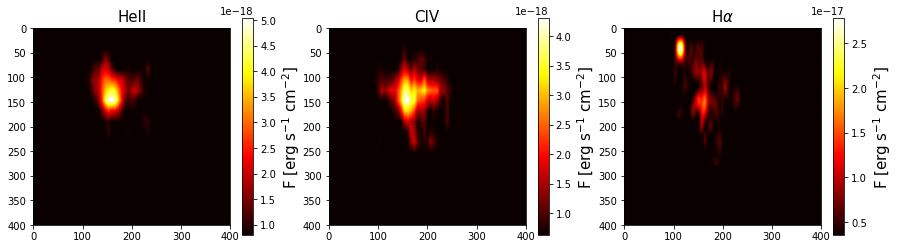

In [13]:
fig,ax=plt.subplots(1,3)
img=ax[0].imshow(heii_img,cmap='hot')
ax[0].set_title('HeII',fontsize=15)
cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'F [erg s$^{-1}$ cm$^{-2}$]',fontsize=15)
img=ax[1].imshow(civ_img,cmap='hot')
ax[1].set_title('CIV',fontsize=15)
cbar=plt.colorbar(img,ax=ax[1])
cbar.ax.set_ylabel(r'F [erg s$^{-1}$ cm$^{-2}$]',fontsize=15)
img=ax[2].imshow(h_alpha_img,cmap='hot')
ax[2].set_title(r'H$\alpha$',fontsize=15)
cbar=plt.colorbar(img,ax=ax[2])
cbar.ax.set_ylabel(r'F [erg s$^{-1}$ cm$^{-2}$]',fontsize=15)
plt.rcParams['figure.figsize'] = [15, 4]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
# plt.savefig(savdic+'NB_img.png',dpi=300)

In [14]:
heii_ly=heii_img/ly_img
civ_ly=civ_img/ly_img

sigma_heii_ly=heii_ly*np.sqrt((1/heiisnr**2)+(1/lysnr**2))
sigma_civ_ly=civ_ly*np.sqrt((1/civsnr**2)+(1/lysnr**2))

heii_h_img=heii_img/h_alpha_img
civ_h_img=civ_img/h_alpha_img

sigma_heii_h=heii_h_img*np.sqrt((1/heiisnr**2)+(1/h_alpha_snr**2))
sigma_civ_h=civ_h_img*np.sqrt((1/civsnr**2)+(1/h_alpha_snr**2))

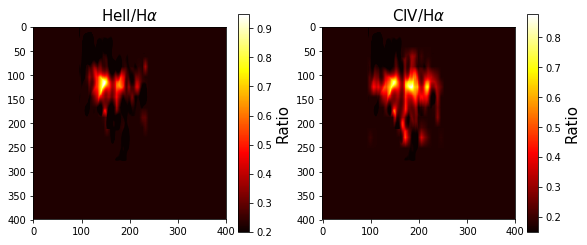

In [16]:
fig,ax=plt.subplots(1,2)
img=ax[0].imshow(heii_h_img,cmap='hot',vmin=.2)
ax[0].set_title(r'HeII/H$\alpha$',fontsize=15)
cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel('Ratio',fontsize=15)
img=ax[1].imshow(civ_h_img,cmap='hot',vmin=.15)
ax[1].set_title(r'CIV/H$\alpha$',fontsize=15)
cbar=plt.colorbar(img,ax=ax[1])
cbar.ax.set_ylabel('Ratio',fontsize=15)
plt.rcParams['figure.figsize'] = [9.5, 4]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
# plt.savefig(savdic+'ratio.png',dpi=300)

In [17]:
r_mesh_h=radiu_profile(ra_inter,dec_inter)

results=img_bin(heii_h_img,civ_h_img,heiisnr,civsnr,h_alpha_snr,sigma_heii_h,sigma_civ_h,
                r_mesh_h,heiivelo,civvelo,heiivsigma,civvsigma,10,10,13,13)
heii_h,civ_h,r_h,sigma_heii_h,sigma_civ_h,heii_v,civ_v,heii_vs,civ_vs,snr_heii=results
r_h=r_h*8.2

heii_h1,civ_h1,r_h1=img_bin2(heii_h_img,heii_h_img,heiisnr,civsnr,h_alpha_snr,
                             r_mesh_h,10,10,13,13)#8,8,20,20//13,13,27,27
r_h1=r_h1*8.2

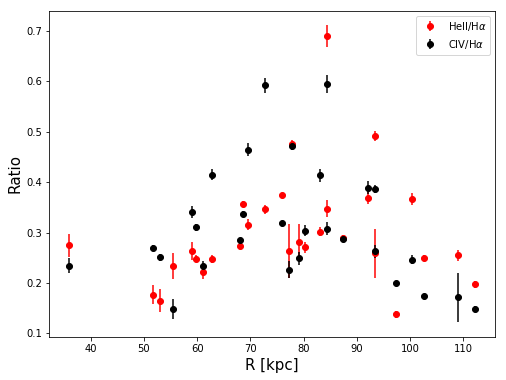

In [19]:
fig,ax=plt.subplots(1,1)
ax.errorbar(r_h,heii_h,yerr=sigma_heii_h*2,fmt='o',c='red',label=r'HeII/H$\alpha$')
ax.errorbar(r_h,civ_h,yerr=sigma_civ_h*2,fmt='o',c='black',label=r'CIV/H$\alpha$')
# plt.yscale('log')
plt.xlabel(r'R [kpc]',fontsize=15)
plt.ylabel(r'Ratio',fontsize=15)
plt.legend()
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

### read the model grid

In [20]:
dic1='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/model_v2/SP/'
model_shock_list=os.listdir(dic1)
model_shock_list=np.array([i for i in model_shock_list if '.csv' in i])
metal_Z=np.array([name[2:7] for name in model_shock_list]).astype(np.float64)

data_list=pd.DataFrame({'name':model_shock_list,'Z':metal_Z})
dataframe=[pd.read_csv(dic1+data_list['name'][j]) for j in range(data_list['name'].shape[0])]
DATA=pd.concat(dataframe)
DATA['heii_h']=DATA['HeII']/DATA['h_alpha']
DATA['civ_h']=DATA['CIV']/DATA['h_alpha']
DATA['heii_ly']=DATA['HeII']/DATA['ly']
DATA['civ_ly']=DATA['CIV']/DATA['ly']
DATA['z']=DATA['z']/0.0183#convert to solar metallicity

In [21]:
np.sort(pd.unique(DATA['density']))

array([1.00e-02, 1.00e-01, 1.00e+00, 1.00e+01, 1.00e+02, 2.15e+02,
       4.63e+02, 1.00e+03, 1.00e+04])

In [22]:
np.sort(pd.unique(DATA['B']))

array([1.000e-04, 1.000e-03, 1.000e-02, 5.000e-02, 1.000e-01, 2.000e-01,
       3.200e-01, 4.000e-01, 5.000e-01, 6.320e-01, 1.000e+00, 1.260e+00,
       1.580e+00, 2.000e+00, 3.160e+00, 3.230e+00, 4.000e+00, 5.000e+00,
       6.320e+00, 1.000e+01, 1.020e+01, 1.265e+01, 1.580e+01, 1.600e+01,
       2.000e+01, 3.000e+01, 3.200e+01, 4.000e+01, 5.000e+01, 6.300e+01,
       1.000e+02, 1.260e+02, 1.600e+02, 3.160e+02, 1.000e+03])

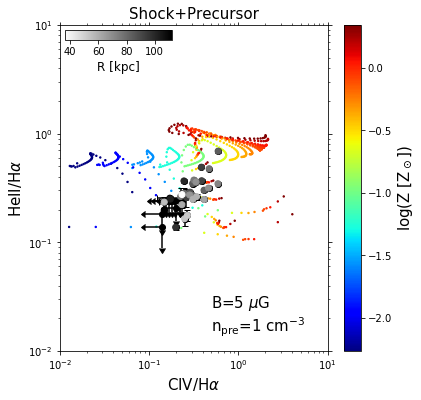

In [35]:
data=DATA[(DATA['ref']=='Gutkin16')&(DATA['script']=='shock_s5_m5113.sh')&(DATA['B']==5)&(DATA['density']==1.)]
fig,ax=plt.subplots(1,1)
img=ax.scatter(data['civ_h'],data['heii_h'],s=2,c=np.log10(data['z']),cmap='jet')
cbar=plt.colorbar(img,ax=ax)
cbar.ax.set_ylabel(r'log(Z [Z$_{\rm \odot}$])',fontsize=15)


img=ax.scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)
cbar_scatter_ax=inset_axes(ax,width="40%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,120,20), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 
ax.errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,fmt='o',color='black',capsize=3)
ax.errorbar(civ_h1,heii_h1,xuplims=np.ones_like(civ_h1),
               xerr=.05*np.ones_like(civ_h1),yerr=.05*np.ones_like(heii_h1),
               uplims=np.ones_like(heii_h1),fmt='o',color='black',capsize=3)

ax.set_title('Shock+Precursor',fontsize=15)
ax.set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax.set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax.text(.5,0.015,r'n$_{\rm pre}$=1 cm$^{-3}$',fontsize=15)
ax.text(.5,0.025,r'B=5 $\mu$G',fontsize=15)
ax.set_ylim(1e-2,10.)
ax.set_xlim(1e-2,10.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()

plt.rcParams['figure.figsize'] = [6, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'sp_n_1.png',dpi=300)

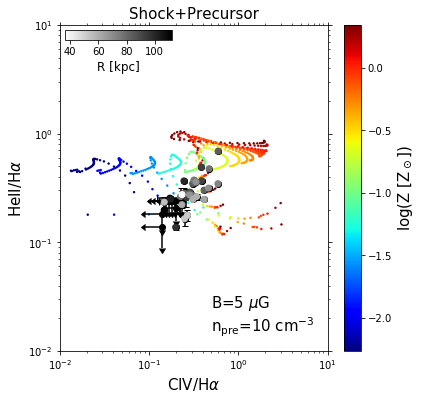

In [41]:
data=DATA[(DATA['ref']=='Gutkin16')&(DATA['script']=='shock_s5_m5113.sh')&(DATA['B']==5)&(DATA['density']==10.)]
fig,ax=plt.subplots(1,1)
img=ax.scatter(data['civ_h'],data['heii_h'],s=2,c=np.log10(data['z']),cmap='jet')
cbar=plt.colorbar(img,ax=ax)
cbar.ax.set_ylabel(r'log(Z [Z$_{\rm \odot}$])',fontsize=15)


img=ax.scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)
cbar_scatter_ax=inset_axes(ax,width="40%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,120,20), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 
ax.errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,fmt='o',color='black',capsize=3)
ax.errorbar(civ_h1,heii_h1,xuplims=np.ones_like(civ_h1),
               xerr=.05*np.ones_like(civ_h1),yerr=.05*np.ones_like(heii_h1),
               uplims=np.ones_like(heii_h1),fmt='o',color='black',capsize=3)

ax.set_title('Shock+Precursor',fontsize=15)
ax.set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax.set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax.text(.5,0.015,r'n$_{\rm pre}$=10 cm$^{-3}$',fontsize=15)
ax.text(.5,0.025,r'B=5 $\mu$G',fontsize=15)
ax.set_ylim(1e-2,10.)
ax.set_xlim(1e-2,10.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()

plt.rcParams['figure.figsize'] = [6, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'sp_n_10.png',dpi=300)

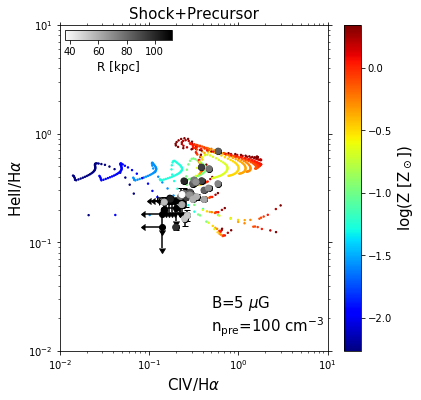

In [42]:
data=DATA[(DATA['ref']=='Gutkin16')&(DATA['script']=='shock_s5_m5113.sh')&(DATA['B']==5)&(DATA['density']==100.)]
fig,ax=plt.subplots(1,1)
img=ax.scatter(data['civ_h'],data['heii_h'],s=2,c=np.log10(data['z']),cmap='jet')
cbar=plt.colorbar(img,ax=ax)
cbar.ax.set_ylabel(r'log(Z [Z$_{\rm \odot}$])',fontsize=15)


img=ax.scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)
cbar_scatter_ax=inset_axes(ax,width="40%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,120,20), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 
ax.errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,fmt='o',color='black',capsize=3)
ax.errorbar(civ_h1,heii_h1,xuplims=np.ones_like(civ_h1),
               xerr=.05*np.ones_like(civ_h1),yerr=.05*np.ones_like(heii_h1),
               uplims=np.ones_like(heii_h1),fmt='o',color='black',capsize=3)

ax.set_title('Shock+Precursor',fontsize=15)
ax.set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax.set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax.text(.5,0.015,r'n$_{\rm pre}$=100 cm$^{-3}$',fontsize=15)
ax.text(.5,0.025,r'B=5 $\mu$G',fontsize=15)
ax.set_ylim(1e-2,10.)
ax.set_xlim(1e-2,10.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()


plt.rcParams['figure.figsize'] = [6, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'sp_n_100.png',dpi=300)

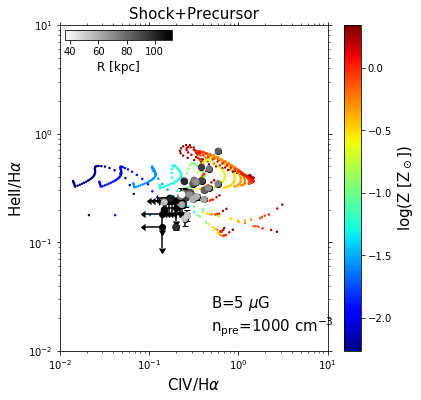

In [43]:
data=DATA[(DATA['ref']=='Gutkin16')&(DATA['script']=='shock_s5_m5113.sh')&(DATA['B']==5)&(DATA['density']==1000.)]
fig,ax=plt.subplots(1,1)
img=ax.scatter(data['civ_h'],data['heii_h'],s=2,c=np.log10(data['z']),cmap='jet')
cbar=plt.colorbar(img,ax=ax)
cbar.ax.set_ylabel(r'log(Z [Z$_{\rm \odot}$])',fontsize=15)


img=ax.scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)
cbar_scatter_ax=inset_axes(ax,width="40%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,120,20), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 
ax.errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,fmt='o',color='black',capsize=3)
ax.errorbar(civ_h1,heii_h1,xuplims=np.ones_like(civ_h1),
               xerr=.05*np.ones_like(civ_h1),yerr=.05*np.ones_like(heii_h1),
               uplims=np.ones_like(heii_h1),fmt='o',color='black',capsize=3)

ax.set_title('Shock+Precursor',fontsize=15)
ax.set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax.set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax.text(.5,0.015,r'n$_{\rm pre}$=1000 cm$^{-3}$',fontsize=15)
ax.text(.5,0.025,r'B=5 $\mu$G',fontsize=15)
ax.set_ylim(1e-2,10.)
ax.set_xlim(1e-2,10.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()

plt.rcParams['figure.figsize'] = [14, 6]
# plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.savefig(savdic+'sp_n_1000.png',dpi=300)

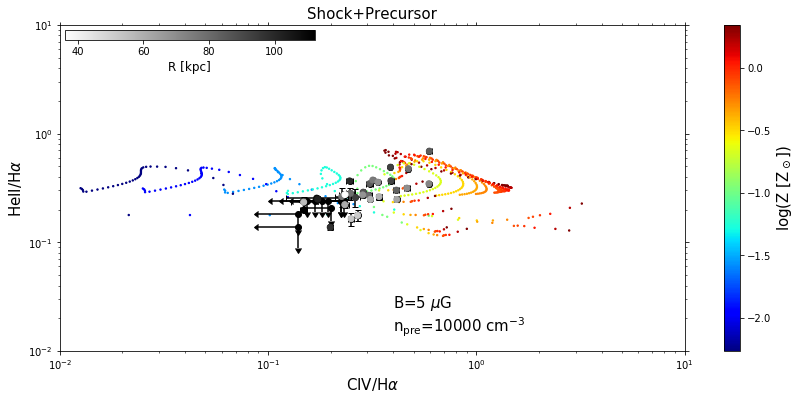

In [44]:
data=DATA[(DATA['ref']=='Gutkin16')&(DATA['script']=='shock_s5_m5113.sh')&(DATA['B']==5)&(DATA['density']==10000.)]
fig,ax=plt.subplots(1,1)
img=ax.scatter(data['civ_h'],data['heii_h'],s=2,c=np.log10(data['z']),cmap='jet')
cbar=plt.colorbar(img,ax=ax)
cbar.ax.set_ylabel(r'log(Z [Z$_{\rm \odot}$])',fontsize=15)


img=ax.scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)
cbar_scatter_ax=inset_axes(ax,width="40%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,120,20), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 
ax.errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,fmt='o',color='black',capsize=3)
ax.errorbar(civ_h1,heii_h1,xuplims=np.ones_like(civ_h1),
               xerr=.05*np.ones_like(civ_h1),yerr=.05*np.ones_like(heii_h1),
               uplims=np.ones_like(heii_h1),fmt='o',color='black',capsize=3)

ax.set_title('Shock+Precursor',fontsize=15)
ax.set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax.set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax.text(.4,0.015,r'n$_{\rm pre}$=10000 cm$^{-3}$',fontsize=15)
ax.text(.4,0.025,r'B=5 $\mu$G',fontsize=15)
ax.set_ylim(1e-2,10.)
ax.set_xlim(1e-2,10.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both',top=True,right=True)
ax.minorticks_on()

plt.rcParams['figure.figsize'] = [6, 6]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
# plt.savefig(savdic+'sp_n_1e4.png',dpi=300)